In [1]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.models import Model
import keras
import numpy as np
import os
from PIL import Image
from keras.utils import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_dataset = tf.keras.utils.image_dataset_from_directory(
  './dataset/',
  shuffle=True,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=4)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  './dataset/',
  shuffle=True,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=4)
train_dataset.class_names

Found 210 files belonging to 5 classes.
Using 168 files for training.
Found 210 files belonging to 5 classes.
Using 42 files for validation.


['cocaine', 'crack drug', 'ecstasy drug', 'methamphetamine', 'weed']

Cut off the top layer acting as a classifier

In [3]:
resnet50_imagenet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

Freeze the layers

In [4]:
resnet50_imagenet_model.trainable = False
print(resnet50_imagenet_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [5]:

model = keras.models.Sequential()
model.add(resnet50_imagenet_model)
'''
model.add(tf.keras.layers.Dense(units=30, activation=tf.keras.activations.relu))
'''
#model.add(tf.keras.layers.Activation(activation=tf.keras.activations.softmax))
model.add(tf.keras.layers.MaxPooling2D(strides=2, pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=30, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=5, activation=tf.keras.activations.softmax))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 30)                552990    
                                                                 
 dense_1 (Dense)             (None, 5)                 155       
                                                                 
Total params: 24,140,857
Trainable params: 553,145
Non-trainable params: 23,587,712
______________________________________

In [6]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15)

Epoch 1/15
42/42 [==============================] - 10s 192ms/step - loss: 2.3100 - accuracy: 0.3452 - val_loss: 1.5448 - val_accuracy: 0.4048
Epoch 2/15
42/42 [==============================] - 9s 208ms/step - loss: 1.0762 - accuracy: 0.6131 - val_loss: 1.1568 - val_accuracy: 0.5238
Epoch 3/15
42/42 [==============================] - 16s 381ms/step - loss: 0.6332 - accuracy: 0.7798 - val_loss: 0.9239 - val_accuracy: 0.6190
Epoch 4/15
42/42 [==============================] - 16s 380ms/step - loss: 0.3690 - accuracy: 0.8810 - val_loss: 0.6981 - val_accuracy: 0.7857
Epoch 5/15
42/42 [==============================] - 16s 378ms/step - loss: 0.2227 - accuracy: 0.9524 - val_loss: 0.5865 - val_accuracy: 0.8095
Epoch 6/15
42/42 [==============================] - 16s 374ms/step - loss: 0.1474 - accuracy: 0.9524 - val_loss: 0.5805 - val_accuracy: 0.8333
Epoch 7/15
42/42 [==============================] - 16s 381ms/step - loss: 0.0928 - accuracy: 0.9702 - val_loss: 0.5567 - val_accuracy: 0.8333


In [7]:
image = load_img('dataset/ecstasy drug/Image_1.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [8]:
yhat = model.predict(image)
model.evaluate(validation_dataset)
print(yhat)

11/11 [==============================] - 4s 325ms/step - loss: 0.6409 - accuracy: 0.8571
[[2.6927219e-07 3.6825827e-07 9.9999940e-01 7.4584527e-10 9.5424724e-10]]


In [9]:
labels = ['cocaine','crack drug','ecstasy drug','methamphetamine','weed']
labels[np.argmax(yhat[0])]

'ecstasy drug'

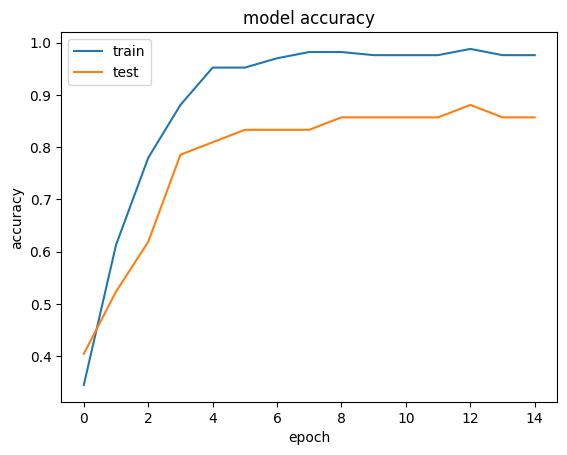

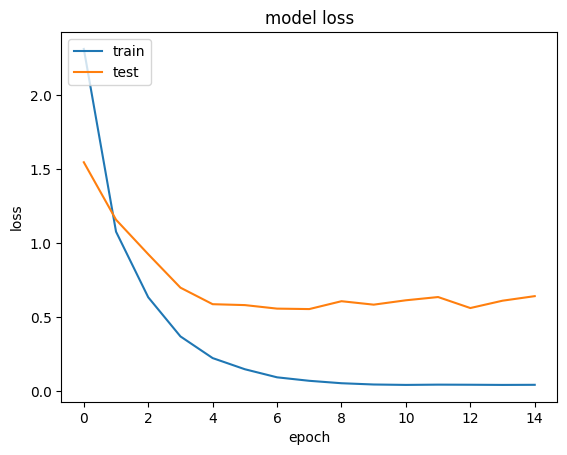

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
raw_resnet50 = ResNet50(include_top=True, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
raw_resnet50.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [14]:
history = raw_resnet50.fit(train_dataset, validation_data=validation_dataset, epochs=15)
raw_resnet50.evaluate(validation_dataset)

Epoch 1/15
42/42 [==============================] - 40s 816ms/step - loss: 7.4017 - accuracy: 0.0119 - val_loss: 7.4440 - val_accuracy: 0.0476
Epoch 2/15
42/42 [==============================] - 35s 824ms/step - loss: 4.0643 - accuracy: 0.3571 - val_loss: 3.2637 - val_accuracy: 0.3571
Epoch 3/15
42/42 [==============================] - 34s 817ms/step - loss: 2.0193 - accuracy: 0.6905 - val_loss: 2.0725 - val_accuracy: 0.5714
Epoch 4/15
42/42 [==============================] - 35s 825ms/step - loss: 1.0737 - accuracy: 0.8452 - val_loss: 1.8005 - val_accuracy: 0.5952
Epoch 5/15
42/42 [==============================] - 35s 839ms/step - loss: 0.6402 - accuracy: 0.8810 - val_loss: 1.9251 - val_accuracy: 0.5952
Epoch 6/15
42/42 [==============================] - 36s 855ms/step - loss: 0.5373 - accuracy: 0.8869 - val_loss: 1.9368 - val_accuracy: 0.5952
Epoch 7/15
42/42 [==============================] - 36s 866ms/step - loss: 0.2786 - accuracy: 0.9583 - val_loss: 2.0719 - val_accuracy: 0.5714

[1.6611497402191162, 0.6428571343421936]

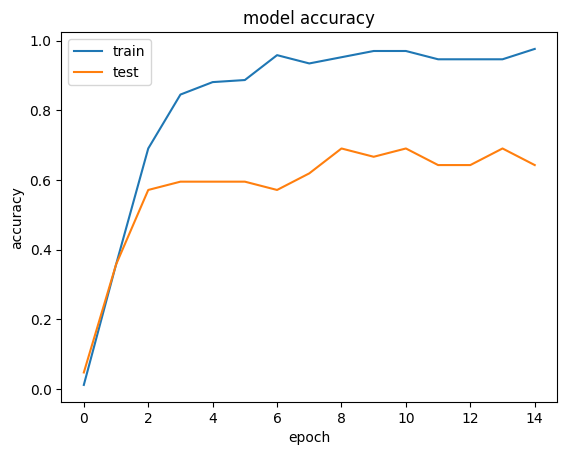

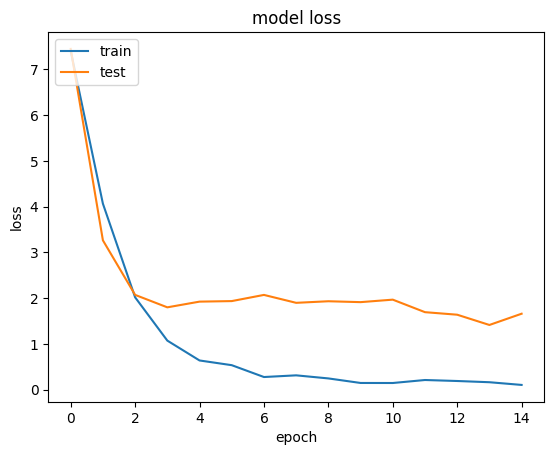

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
simple_model = keras.models.Sequential([])
simple_model.add(tf.keras.layers.InputLayer(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)))
simple_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5)))
simple_model.add(tf.keras.layers.MaxPool2D(strides=2, pool_size=(2, 2)))
simple_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation=tf.keras.activations.relu))
simple_model.add(tf.keras.layers.MaxPool2D(strides=2, pool_size=(2, 2)))
simple_model.add(tf.keras.layers.Flatten())
simple_model.add(tf.keras.layers.Dense(units=30, activation=tf.keras.activations.relu))
simple_model.add(tf.keras.layers.Dense(units=5, activation=tf.keras.activations.softmax, name='logits'))

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [17]:
history = simple_model.fit(train_dataset, validation_data=validation_dataset, epochs=15)
simple_model.evaluate(validation_dataset)

Epoch 1/15
42/42 [==============================] - 7s 155ms/step - loss: 155.6960 - accuracy: 0.2440 - val_loss: 4.2382 - val_accuracy: 0.2857
Epoch 2/15
42/42 [==============================] - 6s 147ms/step - loss: 2.1071 - accuracy: 0.3333 - val_loss: 3.0823 - val_accuracy: 0.1905
Epoch 3/15
42/42 [==============================] - 6s 143ms/step - loss: 1.4416 - accuracy: 0.4167 - val_loss: 2.5495 - val_accuracy: 0.2143
Epoch 4/15
42/42 [==============================] - 6s 145ms/step - loss: 1.2556 - accuracy: 0.4762 - val_loss: 2.3810 - val_accuracy: 0.2619
Epoch 5/15
42/42 [==============================] - 6s 149ms/step - loss: 0.9924 - accuracy: 0.5536 - val_loss: 3.2481 - val_accuracy: 0.3095
Epoch 6/15
42/42 [==============================] - 6s 142ms/step - loss: 0.8784 - accuracy: 0.6548 - val_loss: 3.0796 - val_accuracy: 0.4048
Epoch 7/15
42/42 [==============================] - 6s 137ms/step - loss: 0.7573 - accuracy: 0.7440 - val_loss: 3.2596 - val_accuracy: 0.2857
Epoc

[3.8966710567474365, 0.2142857164144516]

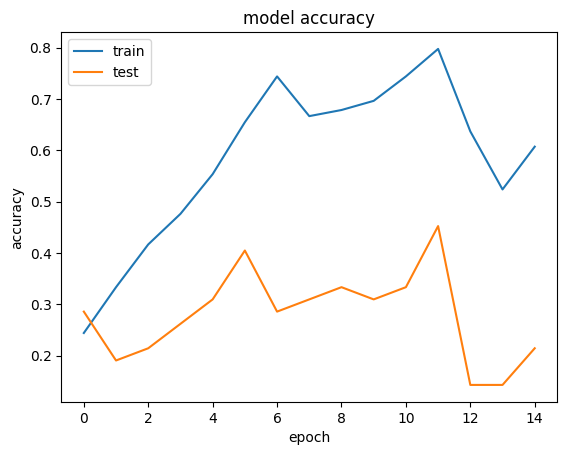

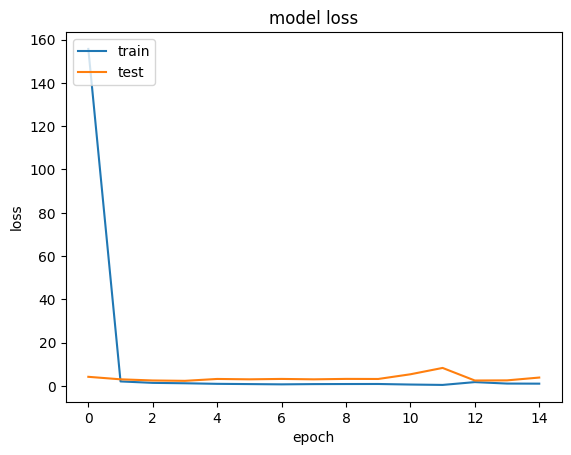

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()